# Credit Card Default Clients in Taiwan Analysis

Trying to predict the likelihood of credit card default for clients in Taiwan, dataset provided by UCI (https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients)

## Motivation

In a well-developed financial system, effective crisis management and robust risk prediction are critical components. Risk prediction aims to utilize financial information, such as business financial statements, customer transactions, and repayment records, to forecast business performance or individual customers' credit risk, thereby reducing potential damage and uncertainty.

Beginning in 1990, the Taiwanese government allowed the formation of new banks. Initially, these banks focused on lending large sums to real estate companies. However, as the real estate market became saturated, these banks shifted their focus to credit cards and cash cards. They aggressively issued credit cards, often lowering approval requirements to attract more customers, including young people with insufficient income. This resulted in widespread overuse of credit cards, leading to significant debt accumulation. By February 2006, debt from credit cards and cash cards in Taiwan had reached $268 billion USD, with over half a million people unable to repay their loans, becoming "credit card slaves." This term refers to individuals who can only pay the minimum balance on their credit card debt each month. The societal repercussions were severe, including increased suicide rates, homelessness, inability to afford education, and engagement in illegal activities to repay debts. The Taiwanese government was compelled to address these issues to stabilize the financial system and mitigate further societal problems.

This project aims to develop a reliable predictive model to identify individuals likely to default on their credit cards. By leveraging client information and historical transaction data, our goal is to create an automated system capable of pinpointing key factors contributing to credit card defaults. Such a model would enable banks to proactively address potential defaults by offering alternative solutions, such as forbearance or debt consolidation, thereby mitigating losses and supporting customers in managing their financial obligations.

Growing up in Taiwan, I witnessed firsthand the changes in the financial sector and the impact these changes had on people's lives. My personal connection to Taiwan has motivated me to work on projects that address the challenges faced by banks and cardholders, aiming to create a more secure and reliable financial environment.

###  Importing Libraries

In [60]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier,AdaBoostClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay


## Data Preprocessing 

In [61]:
warnings.filterwarnings('ignore')
df = pd.read_excel("default of credit card clients.xls")
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. 
This study reviewed the literature and used the following 23 variables as explanatory variables:
**LIMIT_BAL** : Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.
**SEX**: Gender (1 = male; 2 = female).
**EDUCATION**: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
**MARRIAGE**: Marital status (1 = married; 2 = single; 3 = others).
**AGE**: Age (year).

**PAY_0 - PAY_6**: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: 
- PAY_0 = the repayment status in September, 2005; 
- PAY_1 = the repayment status in August, 2005; . . .;
- PAY_6 = the repayment status in April, 2005. 
The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.

**BILL_AMT1 - BILL_AMT6**: Amount of bill statement (NT dollar).
- X12 = amount of bill statement in September, 2005; 
- X13 = amount of bill statement in August, 2005; . . .;
- X17 = amount of bill statement in April, 2005. 

**PAY_AMT1 - PAY_AMT6**: Amount of previous payment (NT dollar). 
- X18 = amount paid in September, 2005; 
- X19 = amount paid in August, 2005; . . .;
- X23 = amount paid in April, 2005.

In [62]:
# Transposed to see all variables.
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,30000.0,15000.500000,8660.398374,1.0,7500.75,15000.5,22500.25,30000.0
LIMIT_BAL,30000.0,167484.322667,129747.661567,10000.0,50000.00,140000.0,240000.00,1000000.0
SEX,30000.0,1.603733,0.489129,1.0,1.00,2.0,2.00,2.0
EDUCATION,30000.0,1.853133,0.790349,0.0,1.00,2.0,2.00,6.0
MARRIAGE,30000.0,1.551867,0.521970,0.0,1.00,2.0,2.00,3.0
AGE,30000.0,35.485500,9.217904,21.0,28.00,34.0,41.00,79.0
PAY_0,30000.0,-0.016700,1.123802,-2.0,-1.00,0.0,0.00,8.0
PAY_2,30000.0,-0.133767,1.197186,-2.0,-1.00,0.0,0.00,8.0
PAY_3,30000.0,-0.166200,1.196868,-2.0,-1.00,0.0,0.00,8.0
PAY_4,30000.0,-0.220667,1.169139,-2.0,-1.00,0.0,0.00,8.0


We can see that there are **30,000 clients** in dataset, with an average of **NTD 167484 ( ~ 5193 USD given current exchange rate 25 MAY 2024)** in balance and an average age of **35.5** years old. Also with gender being 1.6, this data set has a greater percentage of women compared to men. 

### Renaming variables:
Renamed the colum default payment next month to Default for sake of simplicity

In [63]:

df.rename(columns={"default payment next month": "Default"}, inplace = True)
df.columns


Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'Default'],
      dtype='object')

## Cleaning Data

**EDUCATION**: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).

**MARRIAGE**: Marital status (1 = married; 2 = single; 3 = others).

If we look at education and marraige specifically, we can see that there are numbers there that don't match the description we were given from above:

In [64]:
print("EDUCATION UNIQUE: ", df.EDUCATION.unique())
print("MARRIAGE UNIQUE: ", df.MARRIAGE.unique())

EDUCATION UNIQUE:  [2 1 3 5 4 6 0]
MARRIAGE UNIQUE:  [1 2 3 0]


We will assume the numbers that are incorreclty labeled fall under the 'others' description 

In [65]:
df['EDUCATION'].replace({0:4,5:4,6:4}, inplace=True) #All 0's 5's and 6's will be replaced by 4
df['MARRIAGE'].replace({0:3}, inplace=True) # All 0's will be replaced with 3 

We also have to scale our data, so that certain variables don't have a larger impact on our result based soley on their relative scale:

In [66]:
## Defining Features and Target
X = df.drop(['Default'], axis=1)

Y = df['Default']


scaler= StandardScaler()
X = scaler.fit_transform(X)

## EDA - Correlation Analysis 
Let's see which variables are correlated with each other:

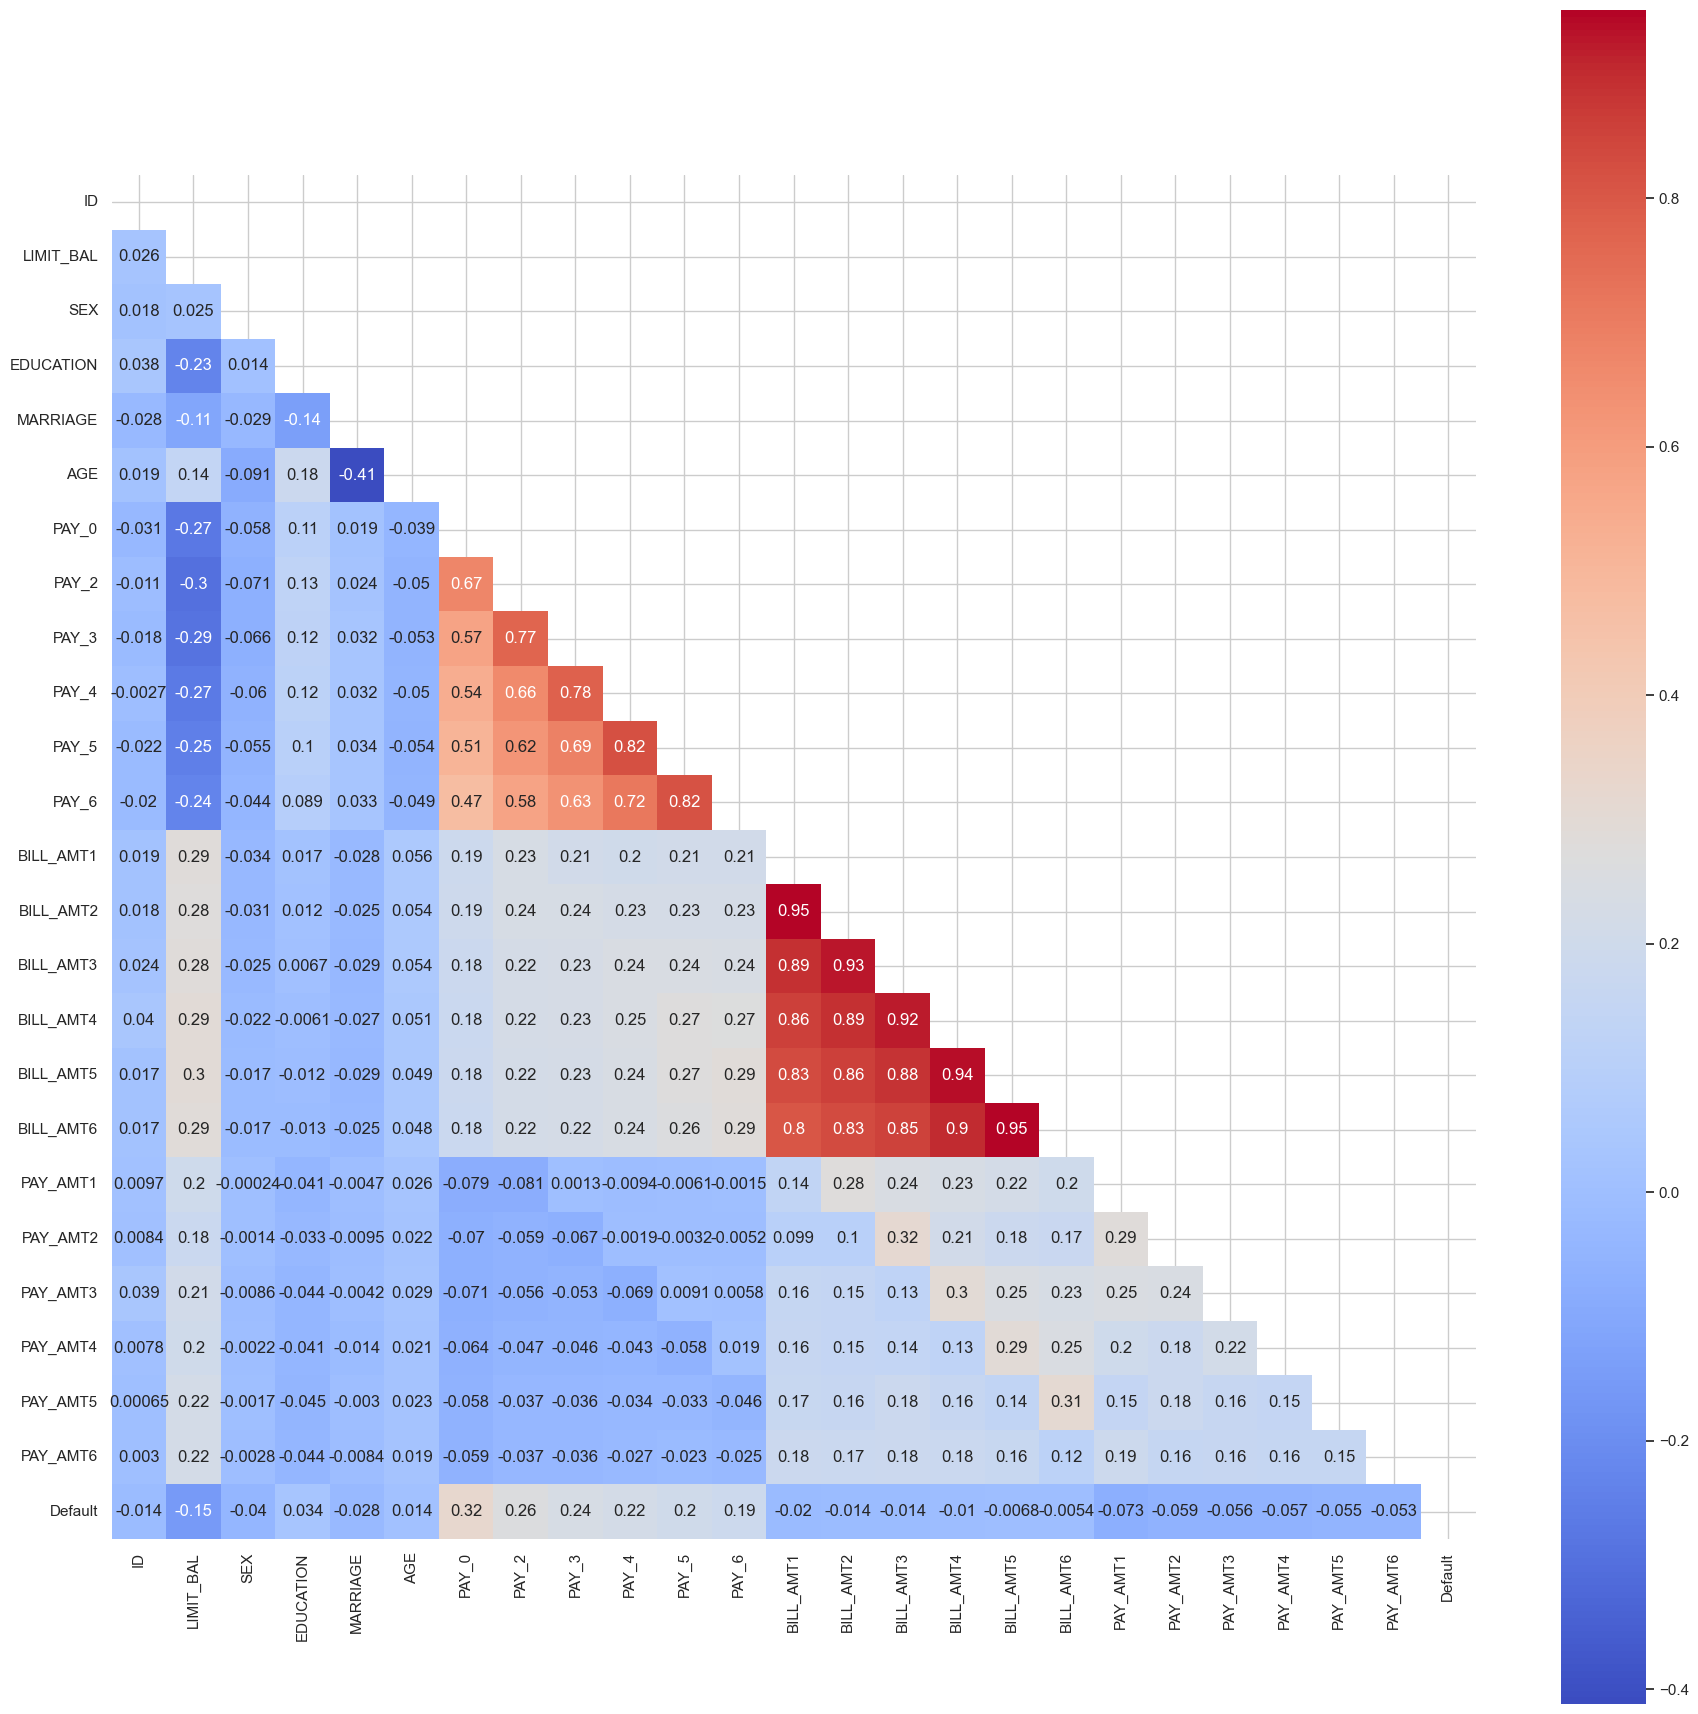

In [67]:
plt.figure(figsize = (22,22))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix,annot = True,square = True, cmap='coolwarm',mask=np.triu(correlation_matrix)) 
plt.show()

Red colors indicate higher correlation, which we see with the payments (PAY_0 - PAY_6) and the bill amounts (BILL_AMT1). 

This is problematic because having highly correlated features provide redundant information, which does not add any new insights to the model. This redundancy can lead to an increase in the complexity of the model without improving its predictive power. 

Highly correlated features can also cause multicollinearity, where the independent variables are highly correlated with each other. This can make it difficult to determine the individual effect of each feature on the target variable, leading to unstable and unreliable estimates of regression coefficients. In the presence of multicollinearity, small changes in the data can cause large variations in the model parameters. This sensitivity can result in models that generalize poorly to new, unseen data, reducing the robustness and reliability of our predictions.

Models with highly correlated features are also prone to overfitting. Overfitting occurs when the model captures the noise in the training data rather than the underlying pattern, leading to poor performance on test data. 

Let's also examine which vriables are the most correlated with our output (Default).

In [68]:

correlations = correlation_matrix['Default'].drop('Default')
top_10_correlated = correlations.abs().sort_values(ascending=False).head(10)
print("Top 10 most correlated variables to 'Default':")
print(top_10_correlated)

Top 10 most correlated variables to 'Default':
PAY_0        0.324794
PAY_2        0.263551
PAY_3        0.235253
PAY_4        0.216614
PAY_5        0.204149
PAY_6        0.186866
LIMIT_BAL    0.153520
PAY_AMT1     0.072929
PAY_AMT2     0.058579
PAY_AMT4     0.056827
Name: Default, dtype: float64


It seems like that past monthly payments are the most correlated with our output variable, which makes sense as it is common knowledge that paying your credit card payments on time is a way to boost your credit score. It will also be interesting to see if these variables will be the principal components that make up our models later on.


## Principal Component Analysis (PCA)

Principal Component Analysis (PCA) is a dimensionality reduction technique that is necessary for several reasons in data analysis and machine learning:

High-dimensional datasets often contain a large number of features, many of which might be redundant or irrelevant. PCA helps reduce the dimensionality of the data by transforming it into a smaller set of uncorrelated variables, called principal components, which capture the most significant variance in the data.

Reducing the number of features simplifies the models and decreases computational requirements. This is particularly important for algorithms that are computationally intensive and may suffer from the ["curse of dimensionality."](https://en.wikipedia.org/wiki/Curse_of_dimensionality)

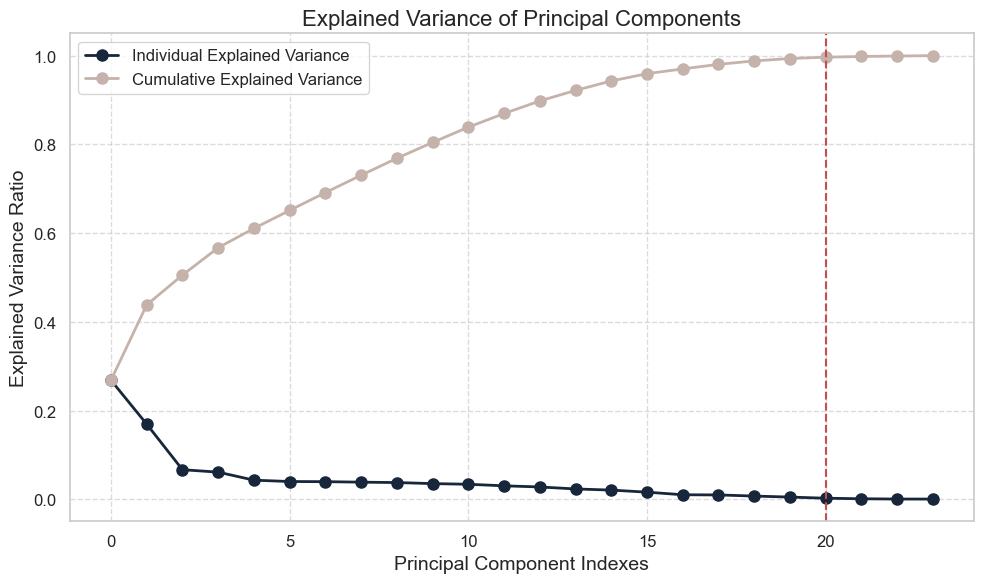

In [69]:
X_train,X_test,Y_train,Y_test= train_test_split(X,Y,test_size=0.20,random_state=42)

pc = X_train.shape[1] #number columns = 25
pca = PCA(n_components=pc)
pca.fit(X_train)

sns.set(style="whitegrid")
colors = ["#17263a", "#c5b2aa"]
plt.figure(figsize=(10, 6))

plt.plot(pca.explained_variance_ratio_, marker='o', color=colors[0], linewidth=2, markersize=8, label='Individual Explained Variance')

plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', color=colors[1], linewidth=2, markersize=8, label='Cumulative Explained Variance')

# Customize the appearance
plt.axvline(20, color='r', linestyle='--', linewidth=1.5)
plt.title('Explained Variance of Principal Components', fontsize=16)
plt.xlabel('Principal Component Indexes', fontsize=14)
plt.ylabel('Explained Variance Ratio', fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Add tight layout and show the plot
plt.tight_layout()
plt.show()

As it seems like nearly 99 % of the variance in our dataset can be explained by the first 19 components, so to reduce our dimensionality, we will only choose these 19 components instead of all 25 to train our model.

In [70]:
pc = 19
pca = PCA(n_components=pc)
pca.fit(X_train)

# Transform the training and test data
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

# Convert the transformed data to DataFrames and set column names
columns = [f'PC{i}' for i in range(1, pc + 1)]
X_train = pd.DataFrame(X_train_pca, columns=columns)
X_test = pd.DataFrame(X_test_pca, columns=columns)

## Data Visualization



### Defaulters Imbalance

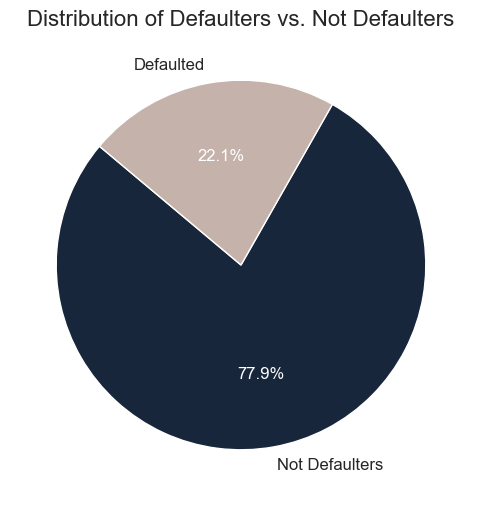

In [71]:

counts = df['Default'].value_counts()
labels = ["Not Defaulters", "Defaulted"]
colors = ["#17263a", "#c5b2aa"]

def make_autopct(colors):
    def inner_autopct(pct):
        return f'{pct:.1f}%' if pct > 0 else ''
    return inner_autopct

plt.figure(figsize=(8, 6))
wedges, texts, autotexts = plt.pie(counts, labels=labels, autopct=make_autopct(colors), startangle=140, colors=colors, textprops={'fontsize': 12})

for autotext in autotexts:
    autotext.set_color('white')

plt.title("Distribution of Defaulters vs. Not Defaulters", fontsize=16)

plt.show()


Only about 22.1% of our data set are those who default

### Gender Imbalance

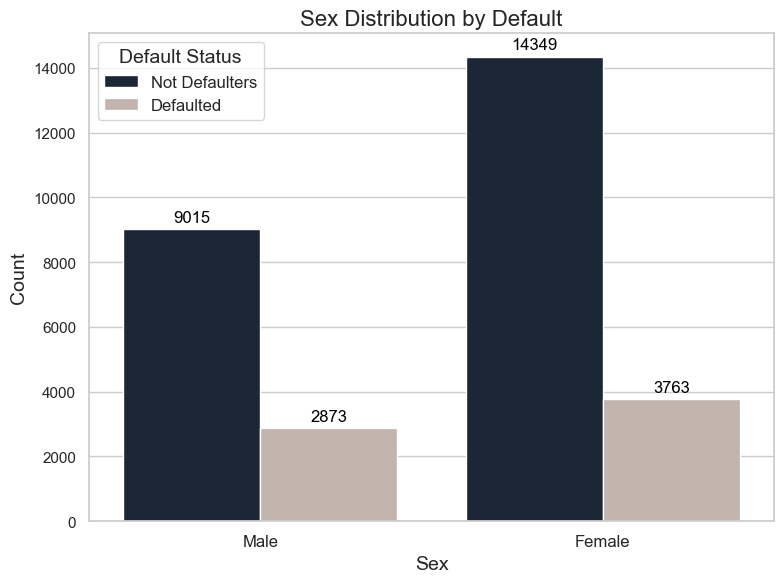

In [72]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df, x="SEX", hue="Default", palette=colors)

for container in ax.containers:
    ax.bar_label(container, label_type='edge', fontsize=12, color='black', padding=3)

plt.xticks([0, 1], labels=["Male", "Female"], fontsize=12)
plt.xlabel("Sex", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title("Sex Distribution by Default", fontsize=16)

legend_labels = ["Not Defaulters", "Defaulted"]
ax.legend(title="Default Status", labels=legend_labels, fontsize=12, title_fontsize=14)

plt.tight_layout()
plt.show()

There are more females than males who own a credit card in our dataset, and a smaller percentage default on their credit card compared to their male counterparts.

### Education Imbalance

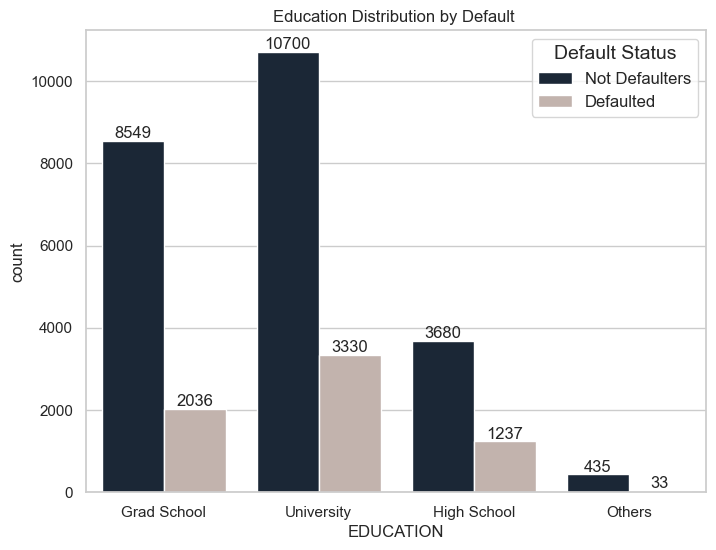

In [73]:
plt.figure(figsize=(8, 6))
ax=sns.countplot(data=df, x="EDUCATION", hue="Default", palette=colors)
for label in ax.containers:
    ax.bar_label(label)
plt.xticks([0,1,2,3], labels=["Grad School", "University",'High School','Others'])
plt.title("Education Distribution by Default ")
ax.legend(title="Default Status", labels=legend_labels, fontsize=12, title_fontsize=14)
plt.show()

University students are the group which highest number customers using credit cards, followed by grad students and then high school students.
It seems like in terms of percentage, high school students have the highest percentage of defaults.

### Age Imbalance

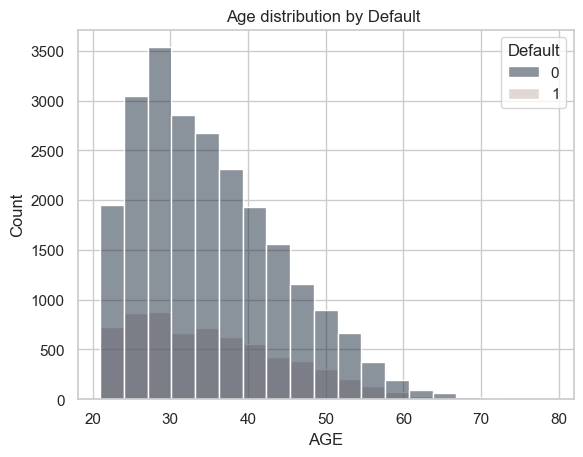

In [74]:

sns.histplot(data=df, x="AGE", hue="Default", binwidth=3, palette = colors)
plt.title("Age distribution by Default ")
ax.legend(title="Default Status", labels=legend_labels, fontsize=12, title_fontsize=14)
plt.show()

As the distribution is right skewed, we can infer that older customers are less likely to use credit cards, while the majority of the customer base is around the age of 30.

## Handling Imbalanced Data

Imbalanced data is a common issue in machine learning and statistical modeling where the distribution of classes within a dataset is uneven. This often occurs in binary classification problems where one class significantly outnumbers the other. In our case, the number of fraudulent transactions (minority class) is much smaller compared to non-fraudulent ones (majority class) etc.

Machine learning algorithms tend to be biased towards the majority class because they aim to minimize overall errors. This may lead to high accuracy but poor performance in predicting the minority class, where a model might achieve high accuracy by predicting the majority class correctly while failing to identify the minority class. 

SMOTE is a data augmentation technique used to combat class imbalance by creating synthetic examples of the minority class. Instead of simply duplicating existing minority class samples, SMOTE generates new samples by interpolating between existing ones. This is done by selecting a minority class sample, finding its k-nearest minority class neighbors, and creating synthetic samples along the line segments joining the sample to its neighbors. This approach helps improve the performance of machine learning models by providing a more balanced and diverse training dataset, reducing the bias towards the majority class. 

KMeans-SMOTE is a step above that, particularly in the context of classification problems. It combines the KMeans clustering algorithm with SMOTE. The process begins by applying KMeans clustering to the minority class data to identify distinct clusters within this class. After clustering, SMOTE is applied to each cluster independently, generating synthetic samples by interpolating between existing samples within each cluster. This approach ensures that the synthetic samples are more diverse and representative of the underlying distribution of the minority class. KMeans-SMOTE is particularly useful in scenarios where the minority class has a complex, multi-modal distribution, and it enhances the performance of classifiers by providing a more balanced and informative training dataset.

Luckily, python has a libary that does this for us:

In [75]:
#from imblearn.over_sampling import KMeansSMOTE
#print("Before oversampling: ",Counter(Y_train))
#oversample = KMeansSMOTE(cluster_balance_threshold=0.00001, random_state=24)
#X_train_SMOTE, Y_train_SMOTE = oversample.fit_resample(X_train, Y_train)
#print("After oversampling: ",Counter(Y_train_SMOTE))

# Models

We can build a variety of models to predict credit card fraud. Amongst the modesl we will be looking at, there will be logistic regression, 


To optimize our models we use the following techniques:

#### Cross Validation
Cross Validation is a technique used to assess the performance of a machine learning model. It involves partitioning the dataset into a set of training and test subsets, and iteratively training and evaluating the model on these subsets. This method helps in determining how well the model generalizes to an independent dataset. One common approach is k-fold cross validation, where the data is divided into `k` subsets (folds), and the model is trained on `k-1` folds while the remaining fold is used for validation. This process is repeated `k` times, with each fold being used exactly once as the validation data. The final evaluation metric is typically the average of the metrics obtained in each fold. Cross validation helps in mitigating the overfitting problem by ensuring that the model performs well on different subsets of data.

#### Grid Search CV
Grid Search CV is a hyperparameter optimization technique used to find the best combination of hyperparameters for a machine learning model. It systematically works through multiple combinations of parameter tunes, cross-validates each combination, and determines which set of parameters works best. In Grid Search CV, a parameter grid is defined, specifying the hyperparameters and the values to be tried. The grid search then evaluates all possible combinations of these hyperparameters using cross-validation. For each combination, the model is trained and validated multiple times (usually using k-fold cross-validation) to ensure that the hyperparameters generalize well to unseen data. The combination with the best cross-validation score is selected as the optimal set of hyperparameters. Grid Search CV is an exhaustive search method and can be computationally expensive, but it ensures that the best possible hyperparameter set is found within the specified grid. 

### Logistic Regression
Logistic regression is a powerful statistical method used in credit card fraud detection to classify transactions as either fraudulent or legitimate. In this context, logistic regression models the probability that a given transaction is fraudulent based on various features such as transaction amount, location, time, and user behavior. By applying a logistic (sigmoid) function to a weighted sum of these input features, the model outputs a probability score between 0 and 1, indicating the likelihood of fraud. This probability can then be used to make binary decisions, flagging transactions that exceed a certain threshold as potentially fraudulent. Logistic regression is favored in fraud detection due to its simplicity and interpretability

Best parameters from GridSearchCV: {'C': 2.782559402207126, 'max_iter': 100, 'solver': 'lbfgs'}
Best number of folds: 10
Best cross-validation score from GridSearchCV: 0.8105
Logit model's accuracy on test set: 0.8098333333333333
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      4687
           1       0.69      0.23      0.35      1313

    accuracy                           0.81      6000
   macro avg       0.76      0.60      0.62      6000
weighted avg       0.79      0.81      0.77      6000



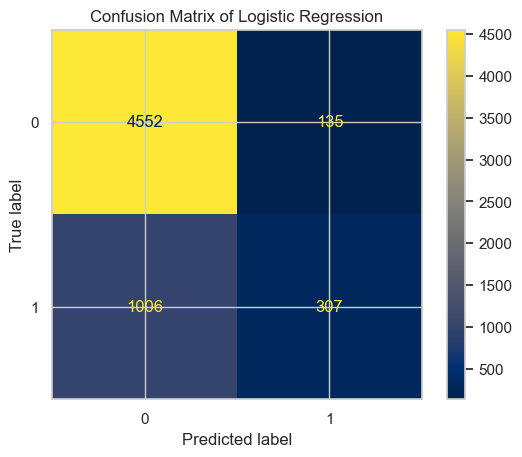

In [76]:

# Define the logistic regression model
logit = LogisticRegression()

# Define the parameter grid
param_grid = {
    'C': np.logspace(-4, 4, 10),  # Regularization parameter
    'solver': ['liblinear', 'lbfgs'],  # Solvers
    'max_iter': [100, 200, 300]  # Maximum number of iterations
}

# Initialize GridSearchCV with StratifiedKFold cross-validation
cv_folds = [3, 5, 7, 10]  # Number of folds to try
best_score = -1
best_params = None

for cv in cv_folds:
    grid_search = GridSearchCV(
        logit,
        param_grid,
        scoring='accuracy',
        cv=StratifiedKFold(n_splits=cv, shuffle=True, random_state=42),
        n_jobs=1  # Use only one core to avoid parallel processing issues
    )
    
    # Fit GridSearchCV
    grid_search.fit(X_train, Y_train)
    
    # Check if the current cv yields a better score
    if grid_search.best_score_ > best_score:
        best_score = grid_search.best_score_
        best_params = grid_search.best_params_
        best_cv = cv

# Print the best parameters and best score
print(f"Best parameters from GridSearchCV: {best_params}")
print(f"Best number of folds: {best_cv}")
print(f"Best cross-validation score from GridSearchCV: {best_score:.4f}")

# Train the model with the best parameters and best cv on the entire training set
logit_best = LogisticRegression(**best_params)
logit_best.fit(X_train, Y_train)

# Make predictions on the test set
pred_logit = logit_best.predict(X_test)

# Print model accuracy on test set
print("Logit model's accuracy on test set:", accuracy_score(Y_test, pred_logit))

# Print classification report
print(classification_report(Y_test, pred_logit))

# Compute and display the confusion matrix
cm = confusion_matrix(Y_test, pred_logit)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logit_best.classes_)
disp.plot(cmap="cividis")  
plt.title('Confusion Matrix of Logistic Regression')
plt.show()



The logistic regression model was evaluated using accuracy, precision, recall, and F1-score. The model achieved a best cross-validation score of 0.8105 with 10-fold cross-validation.

The logistic regression model performs well in predicting non-default cases, as evidenced by the high precision and recall for class 0. However, it struggles with predicting default cases, as indicated by the low recall for class 1. Further improvements are needed to enhance the detection of default cases.

### Decision Tree Classifier 


Trying 3-fold cross-validation
Trying 5-fold cross-validation
Trying 7-fold cross-validation
Trying 10-fold cross-validation
Best parameters from GridSearchCV: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 11, 'min_samples_leaf': 1}
Best number of folds: 7
Best cross-validation score from GridSearchCV: 0.8103
Decision Tree Accuracy on test set: 0.8086666666666666
              precision    recall  f1-score   support

           0       0.84      0.94      0.88      4687
           1       0.61      0.35      0.44      1313

    accuracy                           0.81      6000
   macro avg       0.72      0.64      0.66      6000
weighted avg       0.79      0.81      0.79      6000



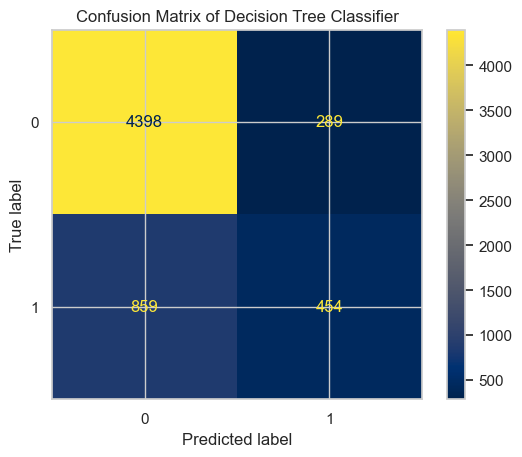

In [77]:
tree = DecisionTreeClassifier(random_state=0)

# Define the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7, 10],
    'max_features': [5, 7, 9, 11],
    'min_samples_leaf': [1, 2, 4]
}

# List of different fold values to try
cv_folds_list = [3, 5, 7, 10]  # Number of folds to try
best_score = -1
best_params = None
best_cv = None

# Loop over different values of cv_folds
for cv_folds in cv_folds_list:
    print(f"Trying {cv_folds}-fold cross-validation")
    grid_search = GridSearchCV(
        tree,
        param_grid,
        scoring='accuracy',
        cv=StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42),
        n_jobs=1  # Use only one core to avoid parallel processing issues
    )
    
    # Fit GridSearchCV
    grid_search.fit(X_train, Y_train)
    
    # Check if the current cv yields a better score
    if grid_search.best_score_ > best_score:
        best_score = grid_search.best_score_
        best_params = grid_search.best_params_
        best_cv = cv_folds

# Print the best parameters and best score
print(f"Best parameters from GridSearchCV: {best_params}")
print(f"Best number of folds: {best_cv}")
print(f"Best cross-validation score from GridSearchCV: {best_score:.4f}")

# Train the model with the best parameters on the entire training set
tree_best = DecisionTreeClassifier(**best_params, random_state=0)
tree_best.fit(X_train, Y_train)

# Make predictions on the test set
pred_tree = tree_best.predict(X_test)

# Print model accuracy on test set
print('Decision Tree Accuracy on test set:', accuracy_score(Y_test, pred_tree))

# Print classification report
print(classification_report(Y_test, pred_tree))

# Compute and display the confusion matrix
cm = confusion_matrix(Y_test, pred_tree)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tree_best.classes_)
disp.plot(cmap="cividis")  # You can change "viridis" to any other colormap
plt.title('Confusion Matrix of Decision Tree Classifier')
plt.show()

The decision tree model was evaluated using multiple cross-validation folds (3, 5, 7, and 10). The best cross-validation score was 0.8114, achieved with 10-fold cross-validation. The optimal hyperparameters were: criterion of 'gini', max_depth of 7, max_features of 9, and min_samples_leaf of 2. 

Comparing the two models, both performed well in predicting non-default cases (class 0), with the logistic regression model achieving a slightly higher recall (0.97 vs. 0.95). However, the decision tree model had a higher precision for class 0 (0.83 vs. 0.82). For default cases (class 1), the decision tree model had a slightly higher recall (0.31 vs. 0.23) but lower precision (0.63 vs. 0.70) compared to the logistic regression model. The F1-scores indicate that the logistic regression model is more balanced in terms of precision and recall for both classes, while the decision tree model performs better in identifying true default cases but with a higher rate of false positives.
The logistic regression model is better suited for balanced performance across both classes, while the decision tree model provides better identification of default cases at the cost of increased false positives.

### Random Forest

Random Forest is an ensemble learning method used for classification, regression, and other tasks. It operates by constructing multiple decision trees during training and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees. The method combines the simplicity of decision trees with the flexibility of bagging, where subsets of data and features are randomly sampled to build each tree. This process helps to improve predictive accuracy and control over-fitting by reducing the variance component of the model's prediction error. Random Forests are widely used due to their robustness, ability to handle large datasets with higher dimensionality, and effectiveness in providing feature importance estimates.



In [78]:
rf = RandomForestClassifier()

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV with StratifiedKFold cross-validation
cv_folds = [3, 5, 7, 10]  # Number of folds to try
best_score = -1
best_params = None

for cv in cv_folds:
    grid_search = GridSearchCV(
        rf,
        param_grid,
        scoring='accuracy',
        cv=StratifiedKFold(n_splits=cv, shuffle=True, random_state=42),
        n_jobs=1
    )
    
    # Fit GridSearchCV
    grid_search.fit(X_train, Y_train)
    
    # Check if the current cv yields a better score
    if grid_search.best_score_ > best_score:
        best_score = grid_search.best_score_
        best_params = grid_search.best_params_
        best_cv = cv

# Print the best parameters and best score
print(f"Best parameters from GridSearchCV: {best_params}")
print(f"Best number of folds: {best_cv}")
print(f"Best cross-validation score from GridSearchCV: {best_score:.4f}")

# Train the model with the best parameters and best cv on the entire training set
rf_best = RandomForestClassifier(**best_params)
rf_best.fit(X_train, Y_train)

# Make predictions on the test set
pred_rf = rf_best.predict(X_test)

# Print model accuracy on the test set
print("Random Forest Accuracy on test set:", accuracy_score(Y_test, pred_rf))

# Print classification report
print(classification_report(Y_test, pred_rf))

# Compute and display the confusion matrix
cm = confusion_matrix(Y_test, pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_best.classes_)
disp.plot(cmap="cividis")
plt.title('Confusion Matrix of Random Forest')
plt.show()

## Boosting 
Boosting is an ensemble learning technique that sequentially trains weak models, like shallow decision trees, to correct the errors of previous models. This process reduces bias and builds a strong classifier by focusing on difficult cases. Random Forest, another ensemble method, reduces variance by averaging predictions from multiple decision trees trained on different data subsets. Combining boosting with Random Forest can enhance model performance by leveraging Random Forest's robustness and boosting's accuracy improvement, resulting in higher accuracy and better generalization in various predictive tasks.['Read More Here'](https://www.cs.cornell.edu/courses/cs578/2005fa/CS578.bagging.boosting.lecture.pdf)


### XGBoost
XGBoost is a popular model for that is an efficient and scalable implementation of gradient boosting, often used in machine learning competitions for its high performance.

In [ ]:
xgboost = xgb.XGBClassifier()

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize GridSearchCV with StratifiedKFold cross-validation
cv_folds = [3, 5, 7, 10]  # Number of folds to try
best_score = -1
best_params = None
best_cv = None

for cv in cv_folds:
    grid_search = GridSearchCV(
        xgboost,
        param_grid,
        scoring='accuracy',
        cv=StratifiedKFold(n_splits=cv, shuffle=True, random_state=42),
        n_jobs=1
    )
    
    # Fit GridSearchCV
    grid_search.fit(X_train, Y_train)
    
    # Check if the current cv yields a better score
    if grid_search.best_score_ > best_score:
        best_score = grid_search.best_score_
        best_params = grid_search.best_params_
        best_cv = cv

# Print the best parameters and best score
print(f"Best parameters from GridSearchCV: {best_params}")
print(f"Best number of folds: {best_cv}")
print(f"Best cross-validation score from GridSearchCV: {best_score:.4f}")

# Train the model with the best parameters and best cv on the entire training set
xgboost_best = xgb.XGBClassifier(**best_params)
xgboost_best.fit(X_train, Y_train)

# Make predictions on the test set
pred_xgb = xgboost_best.predict(X_test)

# Print model accuracy on the test set
print("XGBoost Accuracy on test set:", accuracy_score(Y_test, pred_xgb))

# Print classification report
print(classification_report(Y_test, pred_xgb))

# Compute and display the confusion matrix
cm = confusion_matrix(Y_test, pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgboost_best.classes_)
disp.plot(cmap="cividis")
plt.title('Confusion Matrix of XGBoost')
plt.show()


### ADABoost

AdaBoost, short for Adaptive Boosting, is an ensemble learning technique that combines the outputs of multiple weak learners, typically decision stumps, to create a strong classifier. The key idea behind AdaBoost is to sequentially train weak classifiers, each one focusing on the errors made by the previous classifiers. During each iteration, AdaBoost adjusts the weights of incorrectly classified instances, giving them more importance in the next training round. This process continues until the desired number of weak classifiers is reached. 

AdaBoost should theoretically work better for our instance because it focuses on the mistakes made by previous classifiers, allowing it to improve the performance incrementally with each iteration. In our specific dataset, where some classes or features might be more challenging to classify correctly, AdaBoost's adaptive nature helps in fine-tuning the model by emphasizing these harder-to-classify instances. This iterative re-weighting process ensures that the model pays more attention to the difficult cases, which can lead to better overall accuracy and robustness. Additionally, since AdaBoost combines the outputs of multiple weak classifiers, it can reduce the risk of overfitting compared to a single, more complex model, making it a suitable choice for our classification task.

In [ ]:
adaboost = AdaBoostClassifier()

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0]
}

# Initialize GridSearchCV with StratifiedKFold cross-validation
cv_folds = [3, 5, 7, 10]  # Number of folds to try
best_score = -1
best_params = None
best_cv = None

for cv in cv_folds:
    grid_search = GridSearchCV(
        adaboost,
        param_grid,
        scoring='accuracy',
        cv=StratifiedKFold(n_splits=cv, shuffle=True, random_state=42),
        n_jobs=1
    )
    
    # Fit GridSearchCV
    grid_search.fit(X_train, Y_train)
    
    # Check if the current cv yields a better score
    if grid_search.best_score_ > best_score:
        best_score = grid_search.best_score_
        best_params = grid_search.best_params_
        best_cv = cv

# Print the best parameters and best score
print(f"Best parameters from GridSearchCV: {best_params}")
print(f"Best number of folds: {best_cv}")
print(f"Best cross-validation score from GridSearchCV: {best_score:.4f}")

# Train the model with the best parameters and best cv on the entire training set
adaboost_best = AdaBoostClassifier(**best_params)
adaboost_best.fit(X_train, Y_train)

# Make predictions on the test set
pred_ada = adaboost_best.predict(X_test)

# Print model accuracy on the test set
print("AdaBoost Accuracy on test set:", accuracy_score(Y_test, pred_ada))

# Print classification report
print(classification_report(Y_test, pred_ada))

# Compute and display the confusion matrix
cm = confusion_matrix(Y_test, pred_ada)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=adaboost_best.classes_)
disp.plot(cmap="cividis")
plt.title('Confusion Matrix of AdaBoost')
plt.show()